In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set plot style for better visuals
plt.style.use('seaborn-v0_8')
print("Libraries imported successfully!")

Libraries imported successfully!


In [116]:
# Cell 2: Load and Clean Data (Fixed Version)

import pandas as pd
import numpy as np

# 1. Load the dataset
# low_memory=False prevents warnings regarding mixed data types
df = pd.read_csv('HomeC.csv', low_memory=False)

# 2. Clean column names
# Remove units like ' [kW]' to make column names cleaner (e.g., 'use [kW]' becomes 'use')
df.columns = [col.replace(' [kW]', '').strip() for col in df.columns]

# 3. Handle the 'time' column
# Step A: Force conversion to numeric (invalid parsing will be set to NaN)
df['time'] = pd.to_numeric(df['time'], errors='coerce')
# Step B: Convert Unix timestamp (seconds) to datetime objects
df['time'] = pd.to_datetime(df['time'], unit='s')
# Step C: Set 'time' as the dataframe index for time-series analysis
df = df.set_index('time')

# 4. Resample to Hourly Data
# Fix: We use .select_dtypes(include=[np.number]) to only keep numeric columns.
# This prevents the "TypeError" because we cannot calculate the mean of text columns (like 'Cloudy').
df_hourly = df.select_dtypes(include=[np.number]).resample('h').mean().dropna()

# 5. Verify the output
print("Data Loaded Successfully!")
print("Data Shape:", df_hourly.shape)
print(df_hourly[['use', 'gen', 'temperature']].head())

Data Loaded Successfully!
Data Shape: (140, 28)
                          use       gen  temperature
time                                                
2016-01-01 05:00:00  1.187276  0.038035    33.010339
2016-01-01 06:00:00  1.119695  0.080241    18.775006
2016-01-01 07:00:00  0.953479  0.074560    24.236133
2016-01-01 08:00:00  1.080323  0.013110    39.956900
2016-01-01 09:00:00  1.064834  0.046615    24.463689


In [117]:
# Create a 'Price' column based on Time of Use (ToU)
# Logic:
# - Peak Hours (17:00 - 21:00): Expensive ($0.5/kWh)
# - Off-Peak: Cheap ($0.1/kWh)

df_hourly['Price'] = df_hourly.index.hour.map(lambda x: 0.5 if 17 <= x <= 21 else 0.1)

# Check if price is added correctly
print("Price column added.")
df_hourly[['use', 'Price']].iloc[15:20] # Show some afternoon/evening rows

Price column added.


,use,Price
time,,
2016-01-01 20:00:00,1.175519,0.5
2016-01-01 21:00:00,1.086087,0.5
2016-01-01 22:00:00,1.210736,0.1
2016-01-01 23:00:00,1.242925,0.1
2016-01-02 00:00:00,1.012491,0.1


Training Random Forest Model... (This might take a few seconds)
Model Trained! RMSE (Error): 0.0227 kW


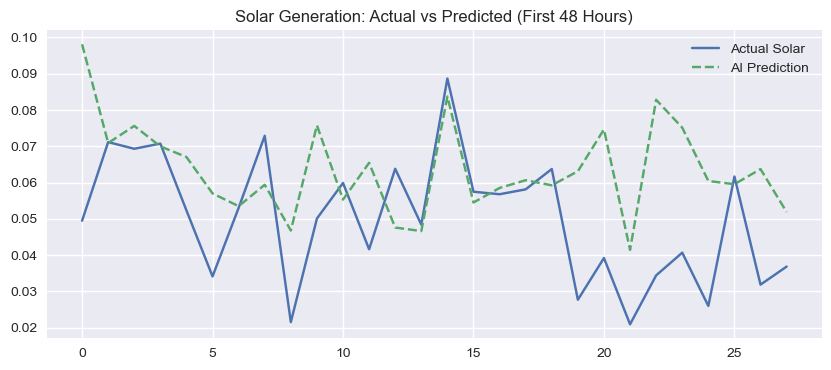

In [118]:
# 1. Define Features (X) and Target (y)
# We use weather data to predict solar generation
feature_cols = ['temperature', 'humidity', 'visibility', 'pressure']
target_col = 'gen'

X = df_hourly[feature_cols]
y = df_hourly[target_col]

# 2. Split Data (80% Train, 20% Test)
# shuffle=False is important for time-series! We can't train on future data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Train Random Forest Model
print("Training Random Forest Model... (This might take a few seconds)")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Evaluate
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model Trained! RMSE (Error): {rmse:.4f} kW")

# Optional: Plot Prediction vs Actual for first 48 hours
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:48], label='Actual Solar')
plt.plot(predictions[:48], label='AI Prediction', linestyle='--')
plt.legend()
plt.title("Solar Generation: Actual vs Predicted (First 48 Hours)")
plt.show()

In [119]:
# Cell 5: Define Fog Node with Time-of-Use (ToU) and FiT Constraints

class FogNode:
    def __init__(self, battery_capacity=20.0):
        self.battery_capacity = battery_capacity
        self.soc = 0.0
        self.log = []
        self.fit_rate = 0.20 # Feed-in Tariff at 20% of retail price

    def run(self, load, solar, price):
        net_load = load - solar
        grid_power = 0.0
        max_power = 5.0

        # Rule 1: Charge from grid during off-peak hours (price < 0.20)
        if price < 0.20 and self.soc < self.battery_capacity:
            charge = min(max_power, self.battery_capacity - self.soc)
            self.soc += charge
            grid_power = net_load + charge

        # Rule 2: Discharge battery to offset load during peak hours (price >= 0.20)
        elif price >= 0.20 and net_load > 0 and self.soc > 0:
            discharge = min(max_power, self.soc, net_load)
            self.soc -= discharge
            grid_power = net_load - discharge

        # Rule 3: Default grid interaction (including free solar charging if net_load < 0)
        else:
            if net_load < 0:
                excess_solar = abs(net_load)
                charge = min(max_power, self.battery_capacity - self.soc, excess_solar)
                self.soc += charge
                grid_power = -(excess_solar - charge)
            else:
                grid_power = net_load

        # Calculate cost based on asymmetric pricing
        if grid_power > 0:
            current_cost = grid_power * price
        else:
            current_cost = grid_power * (price * self.fit_rate)

        self.log.append({"SoC": self.soc, "Cost": current_cost})
        return current_cost

print("FogNode class initialized with ToU logic.")

FogNode class initialized with ToU logic.


In [120]:
# Cell 6: Execute Continuous Simulation

# Ensure simulation runs on sequential continuous data
sim_duration = min(720, len(df_hourly))
fog_node = FogNode(battery_capacity=20.0)
results = []

print(f"Running continuous simulation for {sim_duration} hours...")

for i in range(sim_duration):
    timestamp = df_hourly.index[i]
    real_load = df_hourly['use'].iloc[i]
    real_solar = df_hourly['gen'].iloc[i]
    real_price = df_hourly['Price'].iloc[i]

    # Process fog node control step
    fog_cost = fog_node.run(real_load, real_solar, real_price)

    # Calculate baseline cost with identical 20% FiT constraint
    base_net = real_load - real_solar
    if base_net > 0:
        base_cost = base_net * real_price
    else:
        base_cost = base_net * (real_price * fog_node.fit_rate)

    results.append({
        "Time": timestamp,
        "Base_Cost": base_cost,
        "Fog_Cost": fog_cost
    })

print("Simulation completed.")

Running continuous simulation for 140 hours...
Simulation completed.


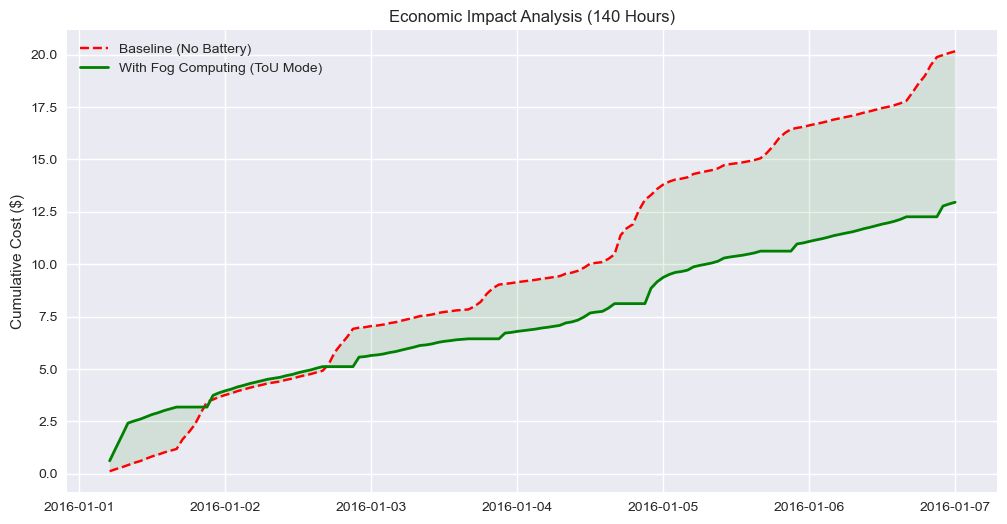

=== Final Simulation Results ===
Total Money Saved: $7.21
Savings Percentage: 35.74%


In [121]:
# Cell 7: Evaluate Financial Impact and Plot Results

import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results).set_index("Time")
cum_base = df_results['Base_Cost'].cumsum()
cum_fog = df_results['Fog_Cost'].cumsum()

# Plot cumulative cost comparison
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, cum_base, label='Baseline (No Battery)', color='red', linestyle='--')
plt.plot(df_results.index, cum_fog, label='With Fog Computing (ToU Mode)', color='green', linewidth=2)
plt.fill_between(df_results.index, cum_base, cum_fog, color='green', alpha=0.1)

plt.ylabel('Cumulative Cost ($)')
plt.title(f'Economic Impact Analysis ({sim_duration} Hours)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate total savings
total_saved = cum_base.iloc[-1] - cum_fog.iloc[-1]
baseline_total = cum_base.iloc[-1]

if baseline_total != 0:
    savings_percentage = (total_saved / baseline_total) * 100
else:
    savings_percentage = 0.0

print("=== Final Simulation Results ===")
print(f"Total Money Saved: ${total_saved:.2f}")
print(f"Savings Percentage: {savings_percentage:.2f}%")
print("================================")